

---


<h3><center>MScFE 690 Capstone</center></h3>
<h3><center>Group 14</center></h3>
<h3><center>Predicting Indian Stock Market Index Movement using Macroeconomic Data and Machine Learning</center></h3>


---

<h3><center>Step 1: Capturing Input Data</center></h3>


Following Macroeconomic variables and Indexs are captured and analyzed for this paper are:

*   FII/DII Activity
*   GDP Growth rate
*   Crude Oil
*   Monetary Policy
*   USD/INR Exchange rates
*   US Global and Indian Market Index
*   Industrial Production
*   CPI

In this notebook, we will download, clean and consolidate these macroeconomic and index data for further steps.

In [ ]:
!pip install yfinance==0.1.74
!pip install pandas_datareader==0.10.0
!pip install nsepython

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import pandas as pd
import nsepython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Accumulate data for last 25 years
start = datetime.datetime (1996, 4, 30)
end = datetime.datetime (2022, 5, 1)
idx = pd.date_range(start, end)

# Picking NSE Data from the NSE python library as Yahoo finance do not have entire history of NSE data.
nse_data = nsepython.index_history("NIFTY 50", start.strftime('%d-%b-%Y'), end.strftime('%d-%b-%Y'))
nse_data['HistoricalDate'] = pd.to_datetime(nse_data['HistoricalDate'])
nse_data.drop(['Index Name', 'INDEX_NAME', 'OPEN', 'HIGH', 'LOW'], axis=1, inplace=True)
nse_data.rename(columns={'CLOSE': 'NSE Adj Close'}, inplace=True)
nse_data = nse_data.set_index('HistoricalDate')
nse_data = nse_data.reindex(idx)
# Ffill for holidays
nse_data = nse_data.fillna(method='ffill')
nse_data.index = nse_data.index.strftime('%Y-%m-%d')
nse_data.index.names = ['Date']

# Picking Dow Jones data from yahoo finance
tickers = ['^DJI'] # Dow Jones index
dow_data = pdr.get_data_yahoo(tickers, start=start, end=end)['Adj Close'].to_frame()
dow_data = dow_data.reindex(idx)
# Ffill for holidays
dow_data = dow_data.fillna(method='ffill')
dow_data.index = dow_data.index.strftime('%Y-%m-%d')
dow_data.rename(columns={'Adj Close': 'Dow Jones Adj Close'}, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Merge the indexs data in single data frames
indexs_data = pd.concat([nse_data, dow_data], axis = 1)
indexs_data

,NSE Adj Close,Dow Jones Adj Close
1996-04-30,1114.30,5569.080078
1996-05-01,1137.80,5575.220215
1996-05-02,1132.00,5498.270020
1996-05-03,1119.40,5478.029785
1996-05-04,1119.40,5478.029785
...,...,...
2022-04-27,17038.40,33301.929688
2022-04-28,17245.05,33916.390625
2022-04-29,17102.55,32977.210938
2022-04-30,17102.55,32977.210938


In [ ]:


# Normalized GDP Data for India (https://fred.stlouisfed.org/series/INDLORSGPNOSTSAM)
gdp_india = pdr.get_data_fred('INDLORSGPNOSTSAM',start, end)
gdp_india.index = gdp_india.index.strftime('%Y-%m-%d')
gdp_india.rename(columns={'INDLORSGPNOSTSAM': 'Norm GDP'}, inplace=True)

# Capturing the oil data
oil_data = pdr.get_data_fred('POILBREUSDM', start, end)
oil_data.index = oil_data.index.strftime('%Y-%m-%d')
oil_data.rename(columns={'POILBREUSDM': 'Brent Crude Price'}, inplace=True)

# CPI Monthly - INDCPIALLMINMEI
cpi_monthly = pdr.get_data_fred('INDCPIALLMINMEI',start, end)
cpi_monthly.index = cpi_monthly.index.strftime('%Y-%m-%d')
cpi_monthly.rename(columns={'INDCPIALLMINMEI': 'CPI'}, inplace=True)

# Industrial production - INDPROINDMISMEI
iip_monthly = pdr.get_data_fred('INDPROINDMISMEI',start, end)
iip_monthly.index = iip_monthly.index.strftime('%Y-%m-%d')
iip_monthly.rename(columns={'INDPROINDMISMEI': 'IIP'}, inplace=True)

# Interest rates - INDIR3TIB01STM monthly or IRSTCB01INM156N Immediate monthly
short_rates_india = pdr.get_data_fred('IRSTCB01INM156N',start, end)
short_rates_india.index = short_rates_india.index.strftime('%Y-%m-%d')
short_rates_india.rename(columns={'IRSTCB01INM156N': 'Central Bank Rates'}, inplace=True)

# Indian Rupees to U.S. Dollar Spot Exchange Rate (DEXINUS)
usd_inr_rates = pdr.get_data_fred('DEXINUS', start, end)
# To accomodate for missing dates in fred data, use ffill for all missing dates
usd_inr_rates = usd_inr_rates.reindex(idx)
usd_inr_rates.index = usd_inr_rates.index.strftime('%Y-%m-%d')
usd_inr_rates.rename(columns={'DEXINUS': 'USD INR Rate'}, inplace=True)
usd_inr_rates = usd_inr_rates.fillna(method='ffill')

# Merge the macro economic variables data in single data frames
macro_data = pd.concat([gdp_india, oil_data, cpi_monthly, iip_monthly, short_rates_india, usd_inr_rates], axis = 1)#.dropna()
macro_data

,Norm GDP,Brent Crude Price,CPI,IIP,Central Bank Rates,USD INR Rate
1996-05-01,100.928058,19.319130,27.196636,34.956089,12.0,34.80
1996-06-01,100.835625,18.577500,27.611219,34.513567,12.0,35.23
1996-07-01,100.743785,19.714783,28.108718,34.114211,12.0,35.10
1996-08-01,100.653025,20.605909,28.440385,34.920563,12.0,35.65
1996-09-01,100.563376,23.081429,28.523301,34.590072,12.0,35.85
...,...,...,...,...,...,...
2022-04-26,NaN,NaN,NaN,NaN,NaN,76.61
2022-04-27,NaN,NaN,NaN,NaN,NaN,76.61
2022-04-28,NaN,NaN,NaN,NaN,NaN,76.66
2022-04-29,NaN,NaN,NaN,NaN,NaN,76.48


In [ ]:
# Merge index data with macro data
all_variables = pd.concat([indexs_data, macro_data], axis = 1)

# Unfortunately, we don't have macroeconomic variables on a daily basis. Hence,
# Filter the data frame based on the available data
all_variables = all_variables[~pd.isnull(all_variables['Norm GDP']) & 
                              ~pd.isnull(all_variables['Brent Crude Price']) &
                              ~pd.isnull(all_variables['CPI']) & 
                              ~pd.isnull(all_variables['IIP']) & 
                              ~pd.isnull(all_variables['Central Bank Rates'])]

all_variables.index.name = 'Date'
all_variables

,NSE Adj Close,Dow Jones Adj Close,Norm GDP,Brent Crude Price,CPI,IIP,Central Bank Rates,USD INR Rate
Date,,,,,,,,
1996-05-01,1137.80,5575.220215,100.928058,19.319130,27.196636,34.956089,12.00,34.80
1996-06-01,1089.90,5643.180176,100.835625,18.577500,27.611219,34.513567,12.00,35.23
1996-07-01,1109.00,5729.979980,100.743785,19.714783,28.108718,34.114211,12.00,35.10
1996-08-01,1036.60,5594.750000,100.653025,20.605909,28.440385,34.920563,12.00,35.65
1996-09-01,1029.00,5616.209961,100.563376,23.081429,28.523301,34.590072,12.00,35.85
...,...,...,...,...,...,...,...,...
2022-01-01,17354.05,36338.300781,99.574644,85.622381,137.830179,119.009911,4.25,74.39
2022-02-01,17576.85,35405.238281,99.517528,94.267000,137.720003,117.988724,4.25,74.78
2022-03-01,16793.90,33294.949219,99.423298,112.440000,138.821763,119.245588,4.25,75.79


In [ ]:
# Save all data to a csv for next steps (feature engineering and ML)
all_variables.to_csv('indexs_and_macroeconomic_data.csv')

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read the input file and set Date as the index
input_data_df = pd.read_csv("indexs_and_macroeconomic_data.csv")
input_data_df = input_data_df.set_index('Date')
input_data_df

,NSE Adj Close,Dow Jones Adj Close,Norm GDP,Brent Crude Price,CPI,IIP,Central Bank Rates,USD INR Rate
Date,,,,,,,,
1996-05-01,1137.80,5575.220215,100.928058,19.319130,27.196636,34.956089,12.00,34.80
1996-06-01,1089.90,5643.180176,100.835625,18.577500,27.611219,34.513567,12.00,35.23
1996-07-01,1109.00,5729.979980,100.743785,19.714783,28.108718,34.114211,12.00,35.10
1996-08-01,1036.60,5594.750000,100.653025,20.605909,28.440385,34.920563,12.00,35.65
1996-09-01,1029.00,5616.209961,100.563376,23.081429,28.523301,34.590072,12.00,35.85
...,...,...,...,...,...,...,...,...
2022-01-01,17354.05,36338.300781,99.574644,85.622381,137.830179,119.009911,4.25,74.39
2022-02-01,17576.85,35405.238281,99.517528,94.267000,137.720003,117.988724,4.25,74.78
2022-03-01,16793.90,33294.949219,99.423298,112.440000,138.821763,119.245588,4.25,75.79


In [ ]:
# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = list(input_data_df.columns)

# Don't normalize the NSE Adj Close Index values (y values)
numeric_vars.pop(0)

input_data_df[numeric_vars] = scaler.fit_transform(input_data_df[numeric_vars])

In [ ]:
print("Scaled input data for all macroeconomic variables and independent variables is given below")
input_data_df

Scaled input data for all macroeconomic variables and independent variables is given below


,NSE Adj Close,Dow Jones Adj Close,Norm GDP,Brent Crude Price,CPI,IIP,Central Bank Rates,USD INR Rate
Date,,,,,,,,
1996-05-01,1137.80,0.000000,0.945585,0.074208,0.000000,0.011073,1.000000,0.000000
1996-06-01,1089.90,0.002209,0.940604,0.068199,0.003607,0.006157,1.000000,0.010317
1996-07-01,1109.00,0.005031,0.935654,0.077414,0.007936,0.001721,1.000000,0.007198
1996-08-01,1036.60,0.000635,0.930763,0.084634,0.010822,0.010678,1.000000,0.020393
1996-09-01,1029.00,0.001332,0.925932,0.104690,0.011543,0.007007,1.000000,0.025192
...,...,...,...,...,...,...,...,...
2022-01-01,17354.05,1.000000,0.872651,0.611402,0.962613,0.944806,0.205128,0.949856
2022-02-01,17576.85,0.969669,0.869573,0.681441,0.961655,0.933462,0.205128,0.959213
2022-03-01,16793.90,0.901071,0.864495,0.828680,0.971241,0.947424,0.205128,0.983445


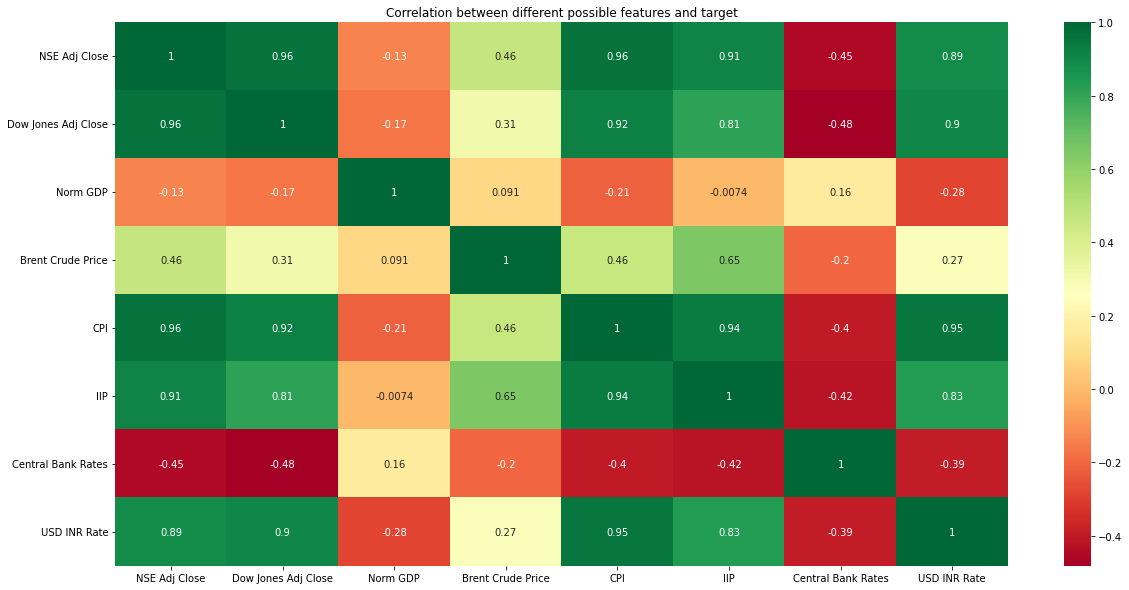

In [ ]:
def feature_imp(data):
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,10))

    # Plot heat map
    g = sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")
    plt.title('Correlation between different possible features and target')
    plt.show()
    return 

feature_imp(input_data_df)

In [ ]:
# Keep a backup of original data frame
backup_input_data_df = input_data_df.copy()

# Ignoring the lesser correlated values for the Linear Regression
input_data_df.drop(['Norm GDP'], axis=1, inplace=True)

# Spliting the data into Independent and Dependent Variables
X = input_data_df.iloc[:,1:]  # Independent Variables
y = input_data_df.iloc[:,:1]  # Dependent Variables

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.7,
                                                    test_size = 0.3, 
                                                    random_state = 40)

In [ ]:
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
X_train = np.linspace(0, 2 * np.pi, 225)
X_train = np.sin(X_train) + np.random.normal(0, 0.4, 225)
encoded = lab_enc.fit_transform(X_train)
X_train = X_train.astype('int')
X_train = X_train.reshape(-1,1)

y_train = np.linspace(0, 2 * np.pi, 225)
y_train = np.sin(y_train) + np.random.normal(0, 0.4, 225)
encoded = lab_enc.fit_transform(y_train)
y_train = y_train.astype('int')
y_train = y_train.reshape(-1,1)


print(utils.multiclass.type_of_target(X_train))


print(utils.multiclass.type_of_target(X_train.astype('int')))


print(utils.multiclass.type_of_target(encoded))

print(utils.multiclass.type_of_target(y_train))


print(utils.multiclass.type_of_target(y_train.astype('int')))


print(utils.multiclass.type_of_target(encoded))




multiclass
multiclass
multiclass
multiclass
multiclass
multiclass


In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [ ]:
y_test = classifier.predict(X_test) 
y_test

ValueError: ignored